In [5]:
import os
import numpy as np
import cv2
from skimage import io
import imutils
import argparse
import dlib

from imutils import paths

In [6]:
def pixel_reader(img, start_horizontal, start_vertical, height):
    black_color = []
    for j in range(-int(height * 1.5), 0):
        for i in range(start_vertical - height, start_vertical + int(height * 1.5)):
            black_lower_range = [80, 50, 50]
            pixel = start_horizontal + j
            color_ci = img[int(pixel), i]
            if ((color_ci[0] <= black_lower_range[0] and color_ci[1] <= black_lower_range[1] and color_ci[2] <= black_lower_range[2])):
                black_color.append([int(pixel), 1])
                
    return black_color

In [3]:
def pixelReader(img,startHorizontal,startVertical,height):
    '''
    Used to read specific pixel of given image.
    img = image 
    startHorizontal =  horizontal starting pixel value
    startVertical = vertical starting value
    height = maximum limit for pixel reading
    '''
    # list for satisfied pixels
    blackColour = []

    # for loops for traversing pixels
    for j in range(-int(height*1.5), 0):
        for i in range(startVertical- height,startVertical+int(height*1.5)):
            # setting lower bound for pixels, termination 
            blackLowerRange = [80, 50, 50]
            pixel = startHorizontal + j
            colorCI = img[int(pixel), i]
            if ((colorCI[0] <= blackLowerRange[0] and colorCI[1] <= blackLowerRange[1] and colorCI[2] <= blackLowerRange[2])):
                blackColour.append([int(pixel), i])
    return blackColour

In [4]:
def getFaceAttributeVector(image):
    '''
    Used to get the 68 facial attributes of face image.
    image: it is an image.
    '''
    # dlib shape predictor 
    predictorPath = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictorPath)
    dets = detector(image)

    # if dlib is able to detect the faces 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for k, d in enumerate(dets):
        shape = predictor(image, d)

    for b in range(68):
        faceCoord[b][0] = shape.part(b).x
        faceCoord[b][1] = shape.part(b).y

    return faceCoord

def getEyeCoordinates(image, faceCoord):
    '''
    Used to crop the eyes from image
    image: it is an image.
    faceCoord: array of facial landmarks coordinates
    '''
    # using facial points to crop the part of the eyes from image
    leftEye = image[int(faceCoord[19][1]):int(faceCoord[42][1]),int(faceCoord[36][0]):int(faceCoord[39][0])]
    rightEye = image[int(faceCoord[19][1]):int(faceCoord[42][1]),int(faceCoord[42][0]):int(faceCoord[45][0])]

    eyeLCoordinate = [int(faceCoord[37][0]+int((faceCoord[38][0]-faceCoord[37][0])/2)), int(faceCoord[38][1]+int((faceCoord[40][1]-faceCoord[38][1])/2))]
    eyeRCoordinate = [int(faceCoord[43][0]+int((faceCoord[44][0]-faceCoord[43][0])/2)), int(faceCoord[43][1]+int((faceCoord[47][1]-faceCoord[43][1])/2))]

    leftBlackPixel = pixelReader(image,eyeLCoordinate[1],eyeLCoordinate[0],int((faceCoord[38][0]-faceCoord[37][0])/2))
    rightBlackPixel = pixelReader(image, eyeRCoordinate[1], eyeRCoordinate[0], int((faceCoord[44][0]-faceCoord[43][0])/2))
    return leftEye, rightEye, leftBlackPixel, rightBlackPixel

def getPupilPoint(img, blackCoordinates, eyeTopPointX, eyeBottomPointY):
    '''
    Used to get the coordinates of the pupil 
    image: cropped eye image
    blackCoordinates: It is the array of the black color pixels inside the eyes
    eyeTopPointX: eye's starting coordinates horizontally
    eyeBottomPointY: eye's starting coordinates vertically
    '''
    # after getting the eyes pixels applying cv2 method to detect circle pixels which we can do using houghcircles 
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    circles = cv2.HoughCircles(gray,cv2.HOUGH_GRADIENT, dp = 1,minDist = 5,
        param1=250,param2=10,minRadius=1,maxRadius=-1)

# check if houghcircles has detect any circle or not
    if circles is not None:
        circles = np.uint16(np.around(circles))
        for i in circles[0,:1]:
            pupilPoint = [int(eyeTopPointX[0])+ i[0],int(eyeBottomPointY[1]) + i[1]]
    else:
        # if HoughCircles is unable to detect the circle than using eyes points to get pupil points 
        a = 0
        for j,k in blackCoordinates:
            if a == int(len(blackCoordinates)/2):
                pupilPoint = [k,j]
            a += 1
    return 

In [7]:
for image_path in sorted(paths.list_images("pupil_images/")):
    print(image_path)
    image = io.imread(image_path)
    image = imutils.resize(image, width=1000)
    
    # dlib shape predictor 
    predictorPath = "shape_predictor_68_face_landmarks.dat"
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor(predictorPath)
    dets = detector(image)

    # if dlib is able to detect the faces 
    shape = None
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    for k, d in enumerate(dets):
        shape = predictor(image, d)
        
    if not shape:
        print("shape missing")
        continue
        
    # to get the 68 facial points detect from dlib into a list
    faceCoord = np.empty([68, 2], dtype = int)

    for b in range(68):
        faceCoord[b][0] = shape.part(b).x
        faceCoord[b][1] = shape.part(b).y
        
    face_vector = faceCoord
    # face_vector = getFaceAttributeVector(image)
    # print(face_vector)
    
    left_eye, right_eye, eye_left_black_pixels, eye_right_black_pixels = getEyeCoordinates(image, face_vector)

    left_eye_coord, eye_brow_coord = face_vector[36], face_vector[19]
    left_pupil_point = getPupilPoint(left_eye, eye_left_black_pixels, left_eye_coord, eye_brow_coord)

    right_eye_coord = face_vector[42]
    right_pupil_point = getPupilPoint(right_eye, eye_right_black_pixels, right_eye_coord, eye_brow_coord)

    if not right_pupil_point or not left_pupil_point:
        print("no_pupil_point(s): ", image_path)
        continue

    cv2.circle(image, tuple(left_pupil_point), 5, (255, 0, 0), -1)
    cv2.circle(image, tuple(right_pupil_point), 5, (255, 0, 0), -1)

    final_image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

pupil_images/pupil_detection_1.png


NameError: name 'getEyeCoordinates' is not defined

In [20]:
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
detector_params = cv2.SimpleBlobDetector_Params()
detector_params.filterByArea = True
detector_params.maxArea = 1500
detector = cv2.SimpleBlobDetector_create(detector_params)

In [21]:
def detect_faces(img, cascade):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    coords = cascade.detectMultiScale(gray_frame, 1.3, 5)
    if len(coords) > 1:
        biggest = (0, 0, 0, 0)
        for i in coords:
            if i[3] > biggest[3]:
                biggest = i
        biggest = np.array([i], np.int32)
    elif len(coords) == 1:
        biggest = coords
    else:
        return None
    for (x, y, w, h) in biggest:
        frame = img[y:y + h, x:x + w]
    return frame


def detect_eyes(img, cascade):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    eyes = cascade.detectMultiScale(gray_frame, 1.3, 5)  # detect eyes
    width = np.size(img, 1)  # get face frame width
    height = np.size(img, 0)  # get face frame height
    left_eye = None
    right_eye = None
    for (x, y, w, h) in eyes:
        if y > height / 2:
            pass
        eyecenter = x + w / 2  # get the eye center
        if eyecenter < width * 0.5:
            left_eye = img[y:y + h, x:x + w]
        else:
            right_eye = img[y:y + h, x:x + w]
    return left_eye, right_eye


def cut_eyebrows(img):
    height, width = img.shape[:2]
    eyebrow_h = int(height / 4)
    img = img[eyebrow_h:height, 0:width]  # cut eyebrows out (15 px)

    return img


def blob_process(img, detector):
    gray_frame = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(gray_frame, 42, 255, cv2.THRESH_BINARY)
    img = cv2.erode(img, None, iterations=2) #1
    img = cv2.dilate(img, None, iterations=4) #2
    img = cv2.medianBlur(img, 5) #3
    keypoints = detector.detect(img)
    return keypoints

pupil_images/pupil_detection_1.png


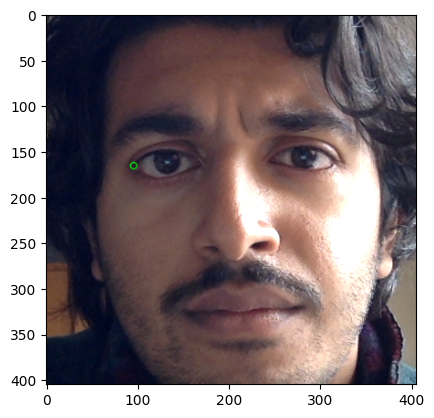

pupil_images/pupil_detection_1_v2.png


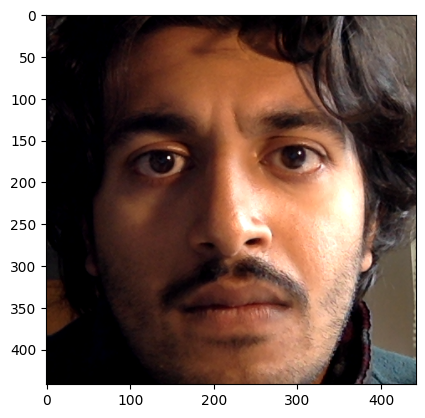

pupil_images/pupil_detection_1_v3.png


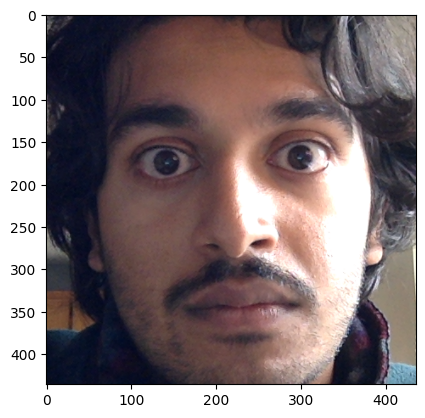

pupil_images/pupil_detection_2.png


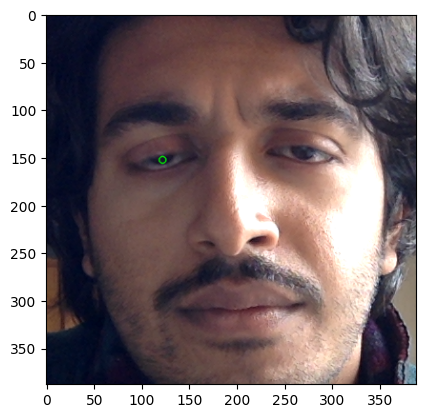

pupil_images/pupil_detection_2_v2.png


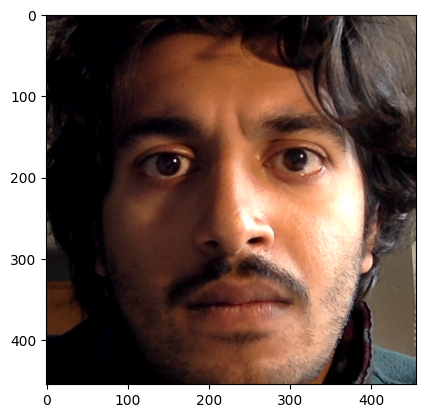

pupil_images/pupil_detection_2_v3.png


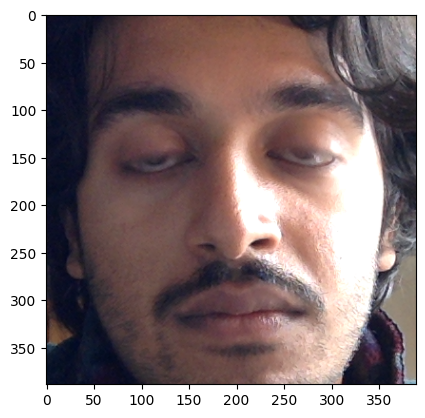

pupil_images/pupil_detection_3.png


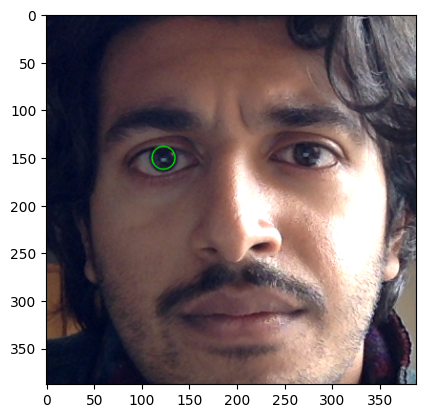

pupil_images/pupil_detection_3_v2.png


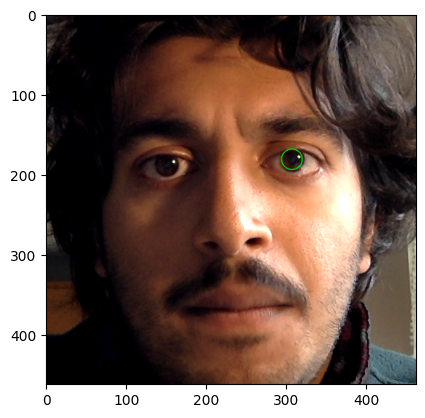

pupil_images/pupil_detection_3_v3.png


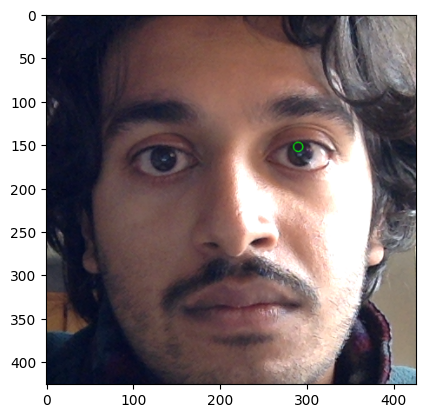

pupil_images/pupil_detection_4.png


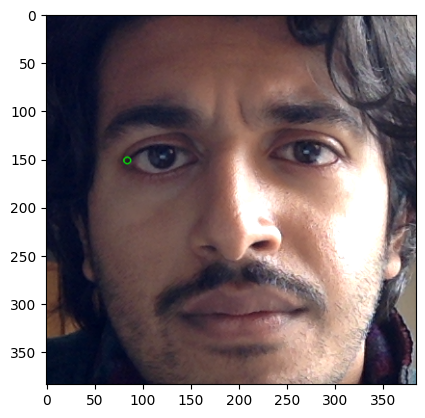

pupil_images/pupil_detection_4_v2.png


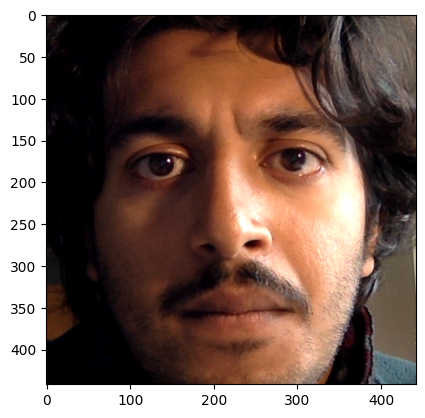

pupil_images/pupil_detection_4_v3.png


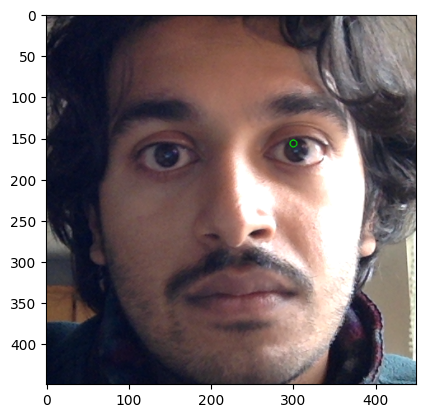

pupil_images/pupil_detection_5.png


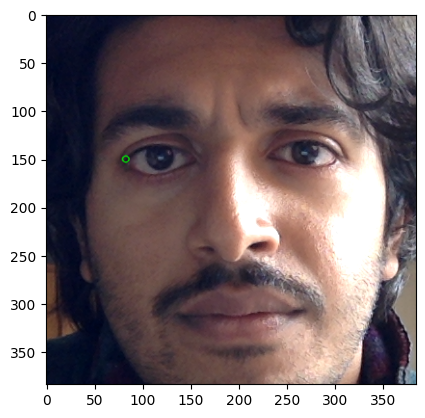

pupil_images/pupil_detection_5_v2.png


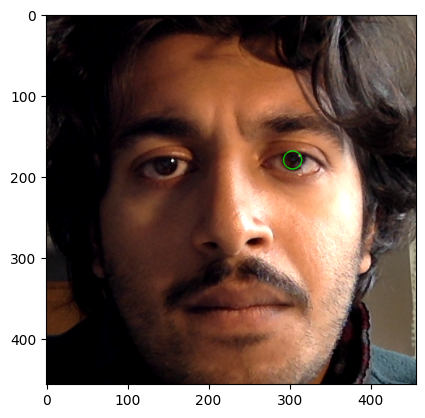

pupil_images/pupil_detection_5_v3.png


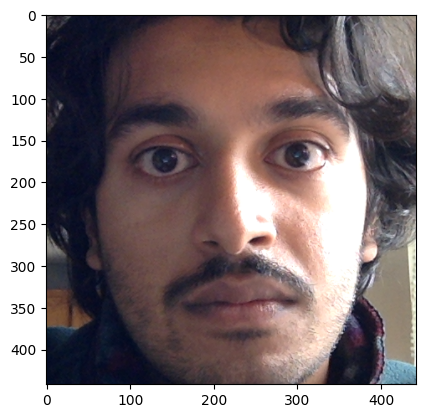

In [22]:
from matplotlib import pyplot as plt

for image_path in sorted(paths.list_images("pupil_images/")):
    print(image_path)
    image = io.imread(image_path)
    frame = image
    face_frame = detect_faces(frame, face_cascade)
    if face_frame is not None:
        eyes = detect_eyes(face_frame, eye_cascade)
        for eye in eyes:
            if eye is not None:
                eye = cut_eyebrows(eye)
                keypoints = blob_process(eye, detector)
                eye = cv2.drawKeypoints(eye, keypoints, eye, (0, 255, 0), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
                
        plt.imshow(face_frame)
        plt.show()
        # cv2.imshow('my image', face_frame)

In [23]:
!pip install pupil-detectors


[notice] A new release of pip available: 22.3.1 -> 23.1
[notice] To update, run: pip install --upgrade pip


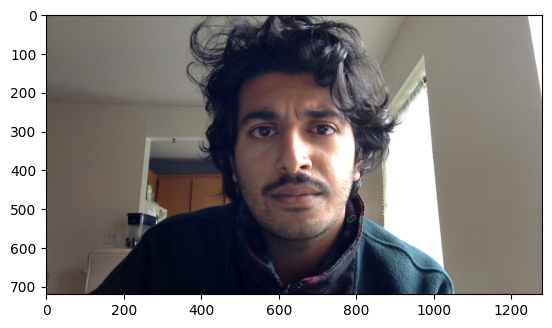

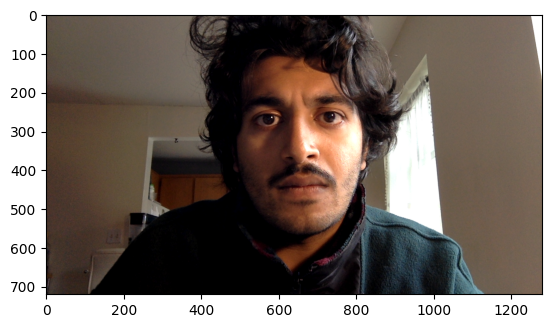

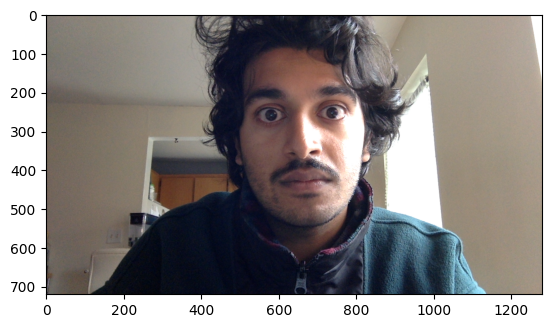

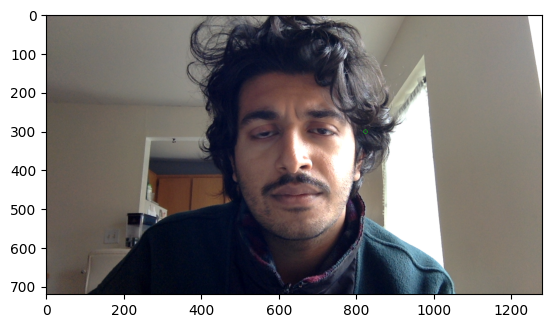

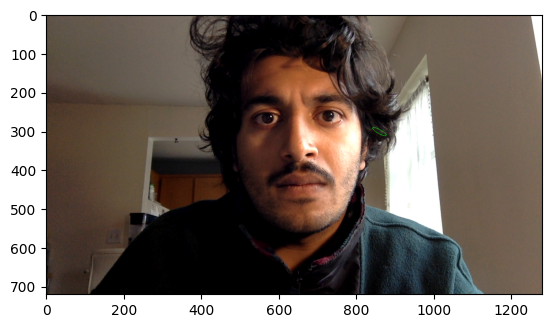

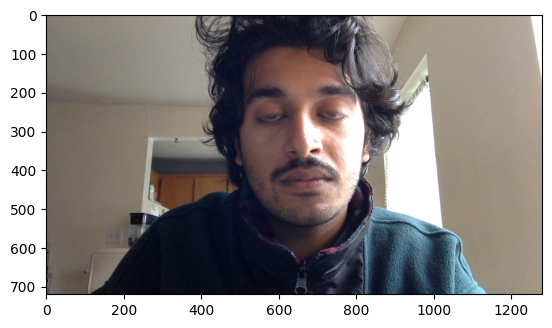

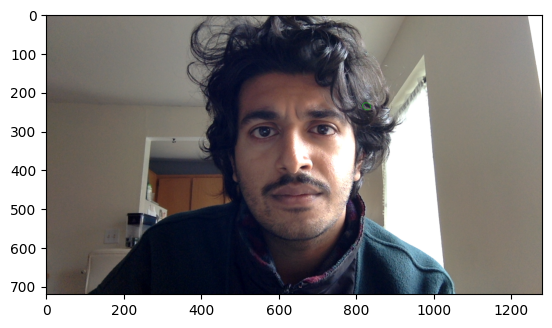

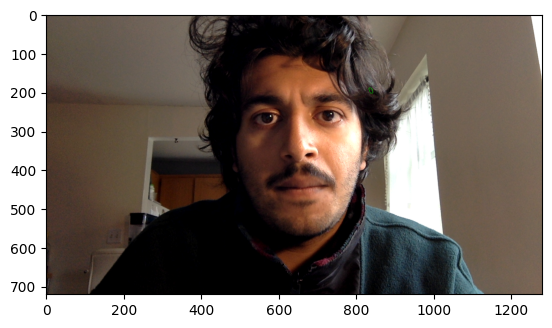

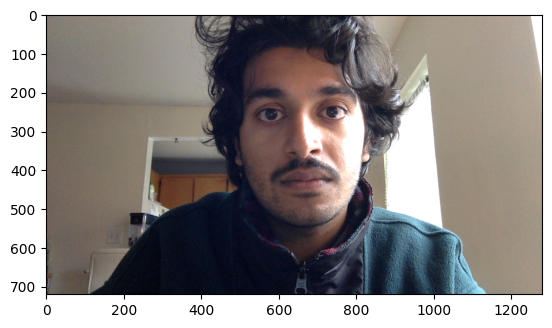

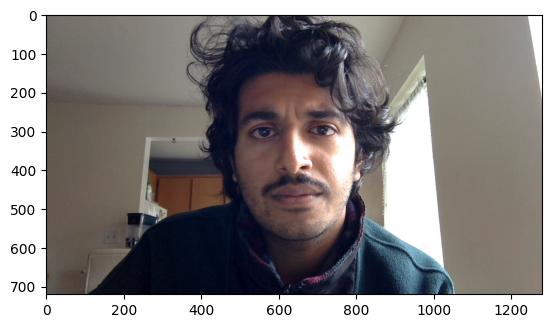

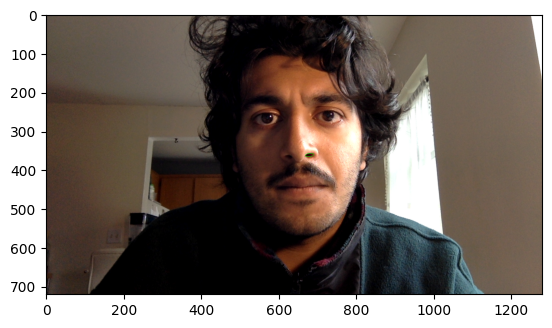

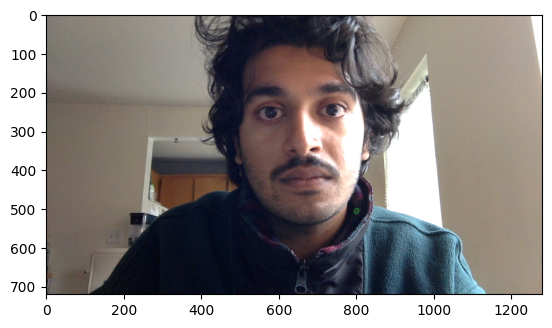

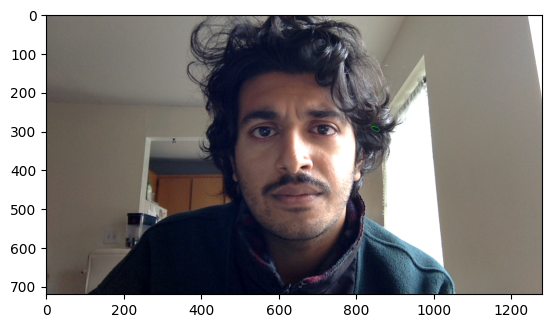

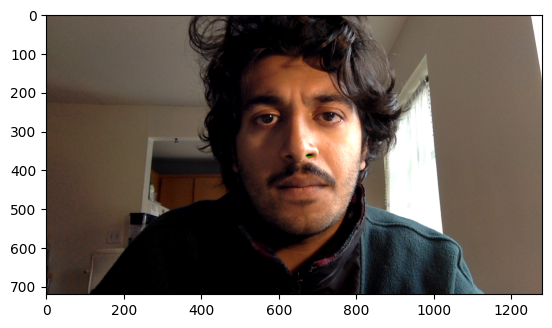

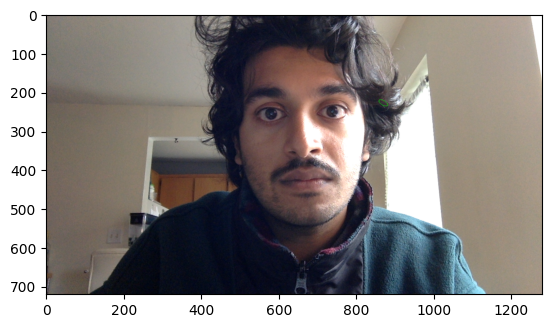

In [24]:
from pupil_detectors import Detector2D

for image_path in sorted(paths.list_images("pupil_images/")):
    detector = Detector2D()

    # read image as numpy array from somewhere, e.g. here from a file
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    result = detector.detect(gray)
    ellipse = result["ellipse"]

    # draw the ellipse outline onto the input image
    # note that cv2.ellipse() cannot deal with float values
    # also it expects the axes to be semi-axes (half the size)
    cv2.ellipse(
       img,
       tuple(int(v) for v in ellipse["center"]),
       tuple(int(v / 2) for v in ellipse["axes"]),
       ellipse["angle"],
       0, 360, # start/end angle for drawing
       (0, 255, 0) # color (BGR): red
    )
    rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(rgb, cmap = plt.cm.Spectral)
    plt.show()
    

In [27]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")

In [25]:
def detect_eye(eye_points, facial_landmarks):
    eye_landmarks_coordinates = np.array(
        [(facial_landmarks.part(eye_points[0]).x,
          facial_landmarks.part(eye_points[0]).y),
         (facial_landmarks.part(eye_points[1]).x,
          facial_landmarks.part(eye_points[1]).y),
         (facial_landmarks.part(eye_points[2]).x,
          facial_landmarks.part(eye_points[2]).y),
         (facial_landmarks.part(eye_points[3]).x,
          facial_landmarks.part(eye_points[3]).y),
         (facial_landmarks.part(eye_points[4]).x,
          facial_landmarks.part(eye_points[4]).y),
         (facial_landmarks.part(eye_points[5]).x,
          facial_landmarks.part(eye_points[5]).y)],
        np.int32)
    return eye_landmarks_coordinates

In [50]:
def get_facial_landmarks(frame):
    faces, _, _ = detector.run(frame, 0, 0)
    facial_landmarks = predictor(frame, faces[0])
    return facial_landmarks

In [130]:
def get_connected_components(thresholded_pupil_region):
    _, _, stats, centroids = cv2.connectedComponentsWithStats(
    thresholded_pupil_region, 4)

    area = []
    index = 0
    for stat in stats:
        print("centroids:")
        print(centroids[index])
        area.append((stat[4], index))
        index = index + 1

    maximum_area = max(area)
    index_of_maximum_area = maximum_area[1]

    pupil_center = centroids[index_of_maximum_area]

    return pupil_center

In [183]:
def get_pupil_bounding_box(eye_landmarks_coordinates):
    min_x = np.min(eye_landmarks_coordinates[:, 0])
    max_x = np.max(eye_landmarks_coordinates[:, 0])
    min_y = np.min(eye_landmarks_coordinates[:, 1])
    max_y = np.max(eye_landmarks_coordinates[:, 1])
    
    return (min_x, min_y, max_x, max_y)

In [318]:
def get_pupil_center_coordinates(eye_landmarks_coordinates, threshold, frame):
    
    min_x = np.min(eye_landmarks_coordinates[:, 0])
    max_x = np.max(eye_landmarks_coordinates[:, 0])
    min_y = np.min(eye_landmarks_coordinates[:, 1])
    max_y = np.max(eye_landmarks_coordinates[:, 1])
    
    eye_landmark_min_x = min_x + 5
    eye_landmark_max_x = max_x - 5
    eye_landmark_min_y = min_y + 1
    eye_landmark_max_y = max_y - 1
    approximate_pupil_region = frame[eye_landmark_min_y: eye_landmark_max_y,
                                     eye_landmark_min_x: eye_landmark_max_x]

    median_blur_filter = cv2.medianBlur(approximate_pupil_region, 5)
    _, thresholded_pupil_region = cv2.threshold(median_blur_filter, threshold, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    
    return get_connected_components(thresholded_pupil_region), (min_x, min_y, max_x, max_y)

In [319]:
test_path = "pupil_images_v2+/v2_pupil_detection_3.png"
image = cv2.imread(test_path)
frame = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
landmarks = get_facial_landmarks(frame)

In [320]:
landmarks_coordinates_left_eye = detect_eye([36, 37, 38, 39, 40, 41], landmarks)
landmarks_coordinates_right_eye = detect_eye([42, 43, 44, 45, 46, 47], landmarks)

In [321]:
landmarks_coordinates_left_eye

array([[482, 325],
       [516, 306],
       [559, 309],
       [593, 339],
       [555, 350],
       [511, 347]], dtype=int32)

In [322]:
landmarks_coordinates_right_eye

array([[744, 335],
       [779, 302],
       [821, 297],
       [850, 314],
       [826, 337],
       [785, 340]], dtype=int32)

In [323]:
pupil_center_left_eye, left_bounds = get_pupil_center_coordinates(landmarks_coordinates_left_eye, 0, frame)
pupil_center_right_eye, right_bounds = get_pupil_center_coordinates(landmarks_coordinates_right_eye, 0, frame)

centroids:
[24.14343598 27.65153971]
centroids:
[60.64770459 17.5508982 ]
centroids:
[ 0.  40.5]
centroids:
[81.87542857 25.84114286]
centroids:
[37.67363607 18.33028422]


In [324]:
left_image = image[left_bounds[1]:left_bounds[3], left_bounds[0]:left_bounds[2]]
left_image = cv2.circle(left_image, (int(pupil_center_left_eye[0]), int(pupil_center_left_eye[1])), radius=5, color=(0, 0, 255), thickness=-1)

right_image = image[right_bounds[1]:right_bounds[3], right_bounds[0]:right_bounds[2]]
right_image = cv2.circle(right_image, (int(pupil_center_right_eye[0]), int(pupil_center_right_eye[1])), radius=5, color=(0, 0, 255), thickness=-1)

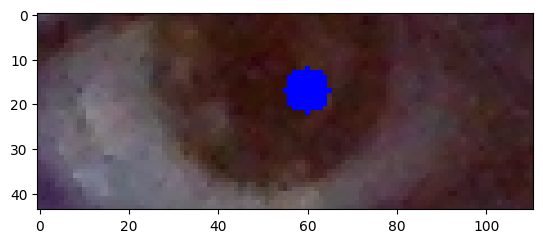

In [325]:
plt.imshow(left_image)
plt.show()

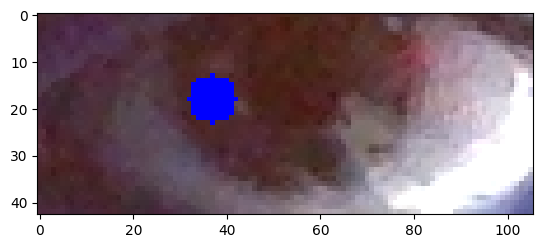

In [326]:
plt.imshow(right_image)
plt.show()

In [311]:
left_bbox = get_pupil_bounding_box(landmarks_coordinates_left_eye)
right_bbox = get_pupil_bounding_box(landmarks_coordinates_right_eye)

In [312]:
left_bbox

(482, 306, 593, 350)

In [313]:
left_width = left_bbox[2] - left_bbox[0]
left_width

111

In [314]:
left_height = left_bbox[3] - left_bbox[1]
left_height

44

In [315]:
right_width = right_bbox[2] - right_bbox[0]
right_width

106

In [316]:
right_height = right_bbox[3] - right_bbox[1]
right_height

43

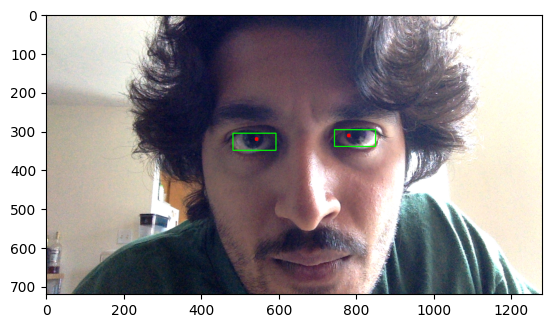

In [317]:
cv2.rectangle(image, (left_bbox[0], left_bbox[1]), (left_bbox[0] + left_width, left_bbox[1] + left_height), (0, 255, 0), 2)
cv2.rectangle(image, (right_bbox[0], right_bbox[1]), (right_bbox[0] + right_width, right_bbox[1] + right_height), (0, 255, 0), 2)
rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb, cmap = plt.cm.Spectral)
plt.imshow(rgb)
plt.show()

In [210]:
pupil_center_left_eye

array([57.61002692, 18.13088829])

In [60]:
pupil_center_left_eye

array([57.61002692, 18.13088829])

In [61]:
pupil_center_right_eye

array([36.15808, 19.33024])